# 1. Loading the required libraries 

In [1]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import sys
import os
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import utils library with custom functions
from utils_finance import *

In [2]:

# Machine Learning libraries
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categorical variables and scaling features

# Regression model and evaluation
from sklearn.linear_model import LinearRegression  # For linear regression models
from sklearn.metrics import mean_squared_error  # For calculating mean squared error (MSE)


# 2. Finding, loading and concat all years of the data 

In [5]:
# Retrieving data 

# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

print(data_path)

# DKB csv files have a cryptic head which needs to be jumped over to make it readable
headerSize = 4

# Make empty list for later concatenation of all df 
dataframes = []

# Reading all data and save them in global variables 
# Iterate through all files in the Data directory
for filename in os.listdir(data_path):
    # Check if the file is a .csv file
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(data_path, filename)

        # Extract the last 4 digits of the filename (before the extension)
        last_four_digits = filename[-8:-4]  # Assumption: There are always 4 digits before the file extension
        
        # Make the year variable 
        year = int(last_four_digits)

        # Read the .csv file into a DataFrame
        print(file_path)
        df = pd.read_csv(file_path, sep=';', skiprows=headerSize, header=0, encoding='utf-8-sig')

        # Save the DataFrame under the desired name
        globals()[f'df_{last_four_digits}'] = df

        # Safe in global list 
        dataframes.append(df)

        # Shape of df 
        print('Shape:', df.shape)
        # Spaltennamen ausgeben
        spaltennamen = df.columns
        print('Column names:', df.columns) 

        df.head()

# Concatenate all data to one big dataframe
df = pd.concat(dataframes, ignore_index=True)


/Users/tillo/Repositoriums/FinanceGrouper/data
/Users/tillo/Repositoriums/FinanceGrouper/data/DKB_transaction_2023.csv
Shape: (534, 12)
Column names: Index(['Buchungsdatum', 'Wertstellung', 'Status', 'Zahlungspflichtige*r',
       'Zahlungsempfänger*in', 'Verwendungszweck', 'Umsatztyp', 'IBAN',
       'Betrag (€)', 'Gläubiger-ID', 'Mandatsreferenz', 'Kundenreferenz'],
      dtype='object')


In [6]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 534 rows, 12 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung      Status Zahlungspflichtige*r  \
0      15.07.24          NaN  Vorgemerkt               ISSUER   
1      29.12.23     01.01.24     Gebucht               DKB AG   
2      29.12.23     29.12.23     Gebucht     Tillmann Stralka   
3      28.12.23     28.12.23     Gebucht        Compl3te GmbH   
4      28.12.23     28.12.23     Gebucht               ISSUER   

                            Zahlungsempfänger*in  \
0       EDEKA Doerflinger. Ulm   Ulm          DE   
1                                         DKB AG   
2  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
3                               Tillmann Stralka   
4                          Netto Marken-Discount   

                                    Verwendungszweck Umsatztyp  \
0  2024-07-15T05:53 Debitk. 0 2099-12 Zahl.System...   Ausgang   
1  Abrechnung 29.12.2023 siehe Anlage Abrechnung ...   Eingan

# 3. First cleaning of data set
+ deleting empty rows and columns 
+ fixing Euro ',' and '.' problem in numbers 
+ changing type of columns to numerical (floats) and types (object)
+ filter all entrances which have very long empty entrys and make them to only one ' '

In [8]:
### Deleting empty columns and rows for each df before saving it in a global variable 
# Identify columns that contain only NaN values
nan_columns = df.columns[df.isna().all()].tolist()    
# Drop the columns with only NaN values
df.drop(columns=nan_columns, inplace=True)
# Delete all rows that are completely empty (i.e., contain only NaN values)
empty_rows = df[df.isna().all(axis=1)].index
df.drop(index=empty_rows, inplace=True)

Set type of data of the columns 

In [9]:
# Fix US / EU decimal-point/comma
df['Betrag (€)'] = df['Betrag (€)'].str.replace('.','')
df['Betrag (€)'] = df['Betrag (€)'].str.replace(',','.')

In [39]:

# All columns will be set accordingly as dtype to what sort of stuff they contain 
df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], format='%d.%m.%y', errors='coerce')
df['Wertstellung'] = pd.to_datetime(df['Wertstellung'], format='%d.%m.%y', errors='coerce')
df['Status'] = df['Status'].astype('category')
df['Zahlungspflichtige*r'] = df['Zahlungspflichtige*r'].astype('string')
df['Zahlungsempfänger*in'] = df['Zahlungsempfänger*in'].astype('string')
df['Verwendungszweck'] = df['Verwendungszweck'].astype('string')
df['Umsatztyp'] = df['Umsatztyp'].astype('category')
df['IBAN'] = df['IBAN'].astype('string')

# Make sure euro is set to string 
df['Betrag (€)'] = df['Betrag (€)'].astype(float)

df['Gläubiger-ID'] = df['Gläubiger-ID'].astype('string')
df['Mandatsreferenz'] = df['Mandatsreferenz'].astype('string')
df['Kundenreferenz'] = df['Kundenreferenz'].astype('string')

#Check if it worked 
inspect_data(df)


🚀 Basic Data Overview
🗂 Shape of the DataFrame: 534 rows, 14 columns

🔍 First 5 rows of the DataFrame:
  Buchungsdatum Wertstellung      Status Zahlungspflichtige*r  \
0    2024-07-15          NaT  Vorgemerkt               ISSUER   
1    2023-12-29   2024-01-01     Gebucht               DKB AG   
2    2023-12-29   2023-12-29     Gebucht     Tillmann Stralka   
3    2023-12-28   2023-12-28     Gebucht        Compl3te GmbH   
4    2023-12-28   2023-12-28     Gebucht               ISSUER   

                            Zahlungsempfänger*in  \
0                  EDEKA Doerflinger. Ulm Ulm DE   
1                                         DKB AG   
2  AMAZON EU S.A R.L., NIEDERLASSUNG DEUTSCHLAND   
3                               Tillmann Stralka   
4                          Netto Marken-Discount   

                                    Verwendungszweck Umsatztyp  \
0  2024-07-15T05:53 Debitk. 0 2099-12 Zahl.System...   Ausgang   
1  Abrechnung 29.12.2023 siehe Anlage Abrechnung ...   Eingan

In [41]:
def reduce_multiple_spaces_and_newlines(df):
    # Function to replace multiple spaces and new lines with a single space
    def clean_text(text):
        if isinstance(text, str):  # Check if the entry is a string
            # Replace newlines and multiple spaces with a single space
            text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
            return text.replace('\n', ' ').strip()  # Replace new lines with a space and strip leading/trailing spaces
        return text  # Return as is if not a string
    
    # Apply the clean_text function to all string columns in the DataFrame
    for col in df.select_dtypes(include=['object', 'string']):
        df[col] = df[col].apply(clean_text)

    return df

# Example usage
df = reduce_multiple_spaces_and_newlines(df)

# 4. Basic analysis of the data 
+ Calculate total income and expenses.
+ Determine monthly savings (income minus expenses).
+ Identify the largest expenses and sources of income.

In [17]:
def basic_analysis(df):
    # Ensure the 'Betrag (€)' column is correctly typed
    df['Betrag (€)'] = pd.to_numeric(df['Betrag (€)'], errors='coerce')

    # Classify income (positive amounts) and expenses (negative amounts)
    income = df[df['Betrag (€)'] > 0]['Betrag (€)'].sum()
    expenses = df[df['Betrag (€)'] < 0]['Betrag (€)'].sum()

    # Calculate monthly savings (income - expenses) by grouping by month
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'])
    df['month'] = df['Buchungsdatum'].dt.to_period('M')
    monthly_savings = df.groupby('month')['Betrag (€)'].sum()

    # Identify the largest expense and largest source of income
    largest_expense = df[df['Betrag (€)'] < 0].nsmallest(1, 'Betrag (€)')
    largest_income = df[df['Betrag (€)'] > 0].nlargest(1, 'Betrag (€)')

    # Find the most frequent income source (who paid the most frequently)
    most_frequent_income_source = df[df['Betrag (€)'] > 0]['Zahlungspflichtige*r'].value_counts().idxmax()

    # Find the most frequent outgoing target (who received money the most frequently)
    most_frequent_expense_target = df[df['Betrag (€)'] < 0]['Zahlungsempfänger*in'].value_counts().idxmax()

    print(f"Total Income: €{income:.2f}")
    print(f"Total Expenses: €{expenses:.2f}")
    print("Monthly Savings:")
    print(monthly_savings)
    print("\nLargest Expense:")
    print(largest_expense[['Buchungsdatum', 'Zahlungsempfänger*in', 'Betrag (€)']])
    print("\nLargest Income:")
    print(largest_income[['Buchungsdatum', 'Zahlungspflichtige*r', 'Betrag (€)']])
    
    print(f"\nMost frequent income source: {most_frequent_income_source}")
    print(f"Most frequent outgoing target: {most_frequent_expense_target}")

# Example usage
basic_analysis(df)


Total Income: €21534.84
Total Expenses: €-22852.59
Monthly Savings:
month
2023-01    -333.00
2023-02     -62.90
2023-03   -1029.69
2023-04   -1349.30
2023-05    -439.47
2023-06     141.61
2023-07     238.90
2023-08     685.58
2023-09     704.10
2023-10     108.34
2023-11    -215.20
2023-12     244.48
2024-07     -11.20
Freq: M, Name: Betrag (€), dtype: float64

Largest Expense:
    Buchungsdatum  Zahlungsempfänger*in  Betrag (€)
470    2023-02-07  IBERIA 0751415725228    -1093.26

Largest Income:
  Buchungsdatum Zahlungspflichtige*r  Betrag (€)
3    2023-12-28        Compl3te GmbH     2137.32

Most frequent income source: Compl3te GmbH
Most frequent outgoing target: 3273 Konsum Rosa Luxemb


# 1. Income and Expense Categorization
+ Categorize transactions by Umsatztyp (e.g., groceries, rent, salary) to provide a breakdown of expenses and income per category. 
+ This helps understand which categories contribute the most to expenses and income.

In [ ]:
def analyze_by_category(df):
    # Group by 'Umsatztyp' and calculate total income and expenses per category
    category_summary = df.groupby('Umsatztyp')['Betrag (€)'].sum()
    print("\nTotal by Category:")
    print(category_summary)

analyze_by_category(df)

# 2. Income vs Expense Trend Over Time 
+ Create a time series analysis to visualize income and expenses trends over time (e.g., monthly, quarterly).


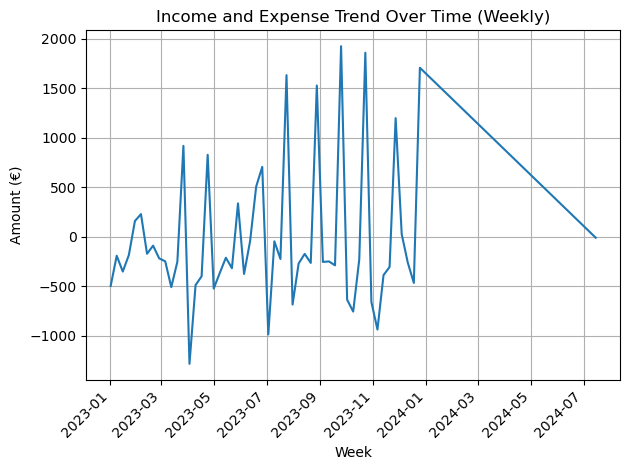

In [23]:
def income_expense_trend(df):
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], errors='coerce')

    # Group by week to see the trend
    df['week'] = df['Buchungsdatum'].dt.to_period('W').apply(lambda r: r.start_time)  # Get the start date of the week
    
    # Group by 'week' and calculate the total for each week
    trend = df.groupby('week')['Betrag (€)'].sum()

    # Plot the trend
    trend.plot(kind='line', title='Income and Expense Trend Over Time (Weekly)', ylabel='Amount (€)', xlabel='Week')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid()  # Add a grid for better readability
    plt.tight_layout()  # Adjust layout
    plt.show()

# Example usage
income_expense_trend(df)


# 3. Average Monthly Income/Expense
Calculate the average monthly income and expense to get an overall view of typical monthly financial activity.

In [25]:
def average_monthly_stats(df):
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], errors='coerce')

    # Create a 'month' column for grouping
    df['month'] = df['Buchungsdatum'].dt.to_period('M')

    # Calculate average monthly income and expenses
    monthly_income = df[df['Betrag (€)'] > 0].groupby('month')['Betrag (€)'].sum().mean()
    monthly_expenses = df[df['Betrag (€)'] < 0].groupby('month')['Betrag (€)'].sum().mean()
    
    print(f"Average Monthly Income: €{monthly_income:.2f}")
    print(f"Average Monthly Expenses: €{monthly_expenses:.2f}")

# Example usage
average_monthly_stats(df)


Average Monthly Income: €1794.57
Average Monthly Expenses: €-1757.89


# 4. Recurring Transactions Detection
Identify recurring transactions such as regular payments (e.g., rent, subscriptions) or income (e.g., salary) based on similar amounts and descriptions.

In [34]:
def detect_recurring_transactions(df):
    # Find recurring transactions based on 'Zahlungsempfänger*in' and 'Betrag (€)'
    recurring = df[df.duplicated(['Zahlungsempfänger*in', 'Betrag (€)'], keep=False)]
    
    print("\nRecurring Transactions:")
    print(recurring[['Buchungsdatum', 'Zahlungsempfänger*in', 'Betrag (€)', 'Verwendungszweck']])
    
    # Summary of recurring transactions
    recurring_summary = recurring.groupby(['Zahlungsempfänger*in', 'Betrag (€)']).size().reset_index(name='Count')
    recurring_summary = recurring_summary.sort_values(by='Count', ascending=False)
    
    print("\nSummary of Recurring Transactions:")
    print(recurring_summary)

    return recurring, recurring_summary


# Call the function and display the first few rows of the recurring transactions
recurring, recurring_summary = detect_recurring_transactions(df)
recurring_summary.head()


Recurring Transactions:
    Buchungsdatum                               Zahlungsempfänger*in  \
1      2023-12-29                                             DKB AG   
23     2023-12-18                                   DRESDNER VERKEHR   
27     2023-12-18                                   DRESDNER VERKEHR   
28     2023-12-18                            DECATHLON Deutschland S   
34     2023-12-14  Telefonica Germany G                          ...   
..            ...                                                ...   
519    2023-01-09                            Boulderhalle Leipzig Gm   
522    2023-01-09                                   PAYPAL .POSTSHOP   
525    2023-01-05                            Boulderhalle Leipzig Gm   
531    2023-01-02                                   Tillmann Stralka   
532    2023-01-02                                       Paul Colditz   

     Betrag (€)                                   Verwendungszweck  
1          0.00  Abrechnung 29.12.2023 si

,Zahlungsempfänger*in,Betrag (€),Count
26,Telefonica Germany G ...,-9.99,12
22,Paul Colditz,-18.00,9
28,Tillmann Stralka,-402.00,9
4,Boulderhalle Leipzig Gm,-8.00,6
30,Transact Eisenbahnst53,-50.00,6


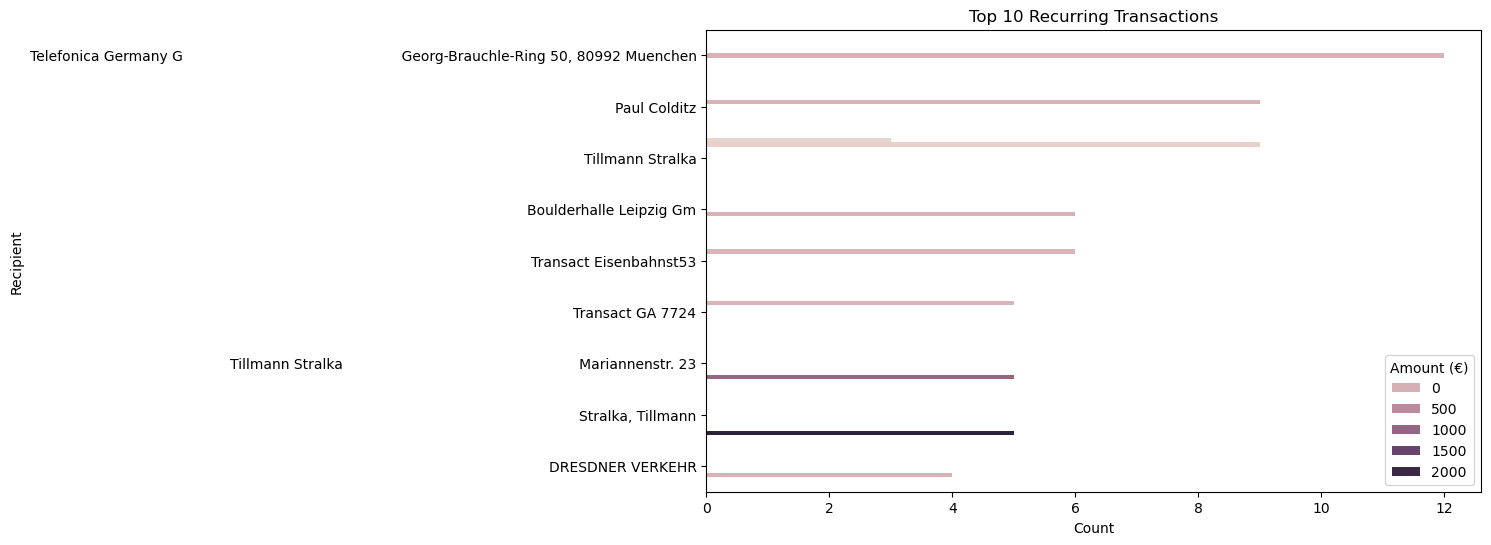

In [42]:
def plot_recurring_summary(recurring_summary):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=recurring_summary.head(10), x='Count', y='Zahlungsempfänger*in', hue='Betrag (€)')
    plt.title('Top 10 Recurring Transactions')
    plt.xlabel('Count')
    plt.ylabel('Recipient')
    plt.legend(title='Amount (€)')
    plt.show()

# Call the plotting function
plot_recurring_summary(recurring_summary)

# 5. Monthly Expense to Income Ratio
Calculate the expense-to-income ratio to determine how much of your income is spent each month.

In [30]:
def expense_income_ratio(df):
    df['month'] = df['Buchungsdatum'].dt.to_period('M')
    income = df[df['Betrag (€)'] > 0].groupby('month')['Betrag (€)'].sum()
    expenses = df[df['Betrag (€)'] < 0].groupby('month')['Betrag (€)'].sum().abs()
    
    ratio = (expenses / income).fillna(0)  # Handle division by zero
    print("\nExpense to Income Ratio per Month:")
    print(ratio)

expense_income_ratio(df)



Expense to Income Ratio per Month:
month
2023-01    1.333333
2023-02    1.023736
2023-03    2.030721
2023-04    2.350651
2023-05    1.439910
2023-06    0.915200
2023-07    0.892981
2023-08    0.679234
2023-09    0.670569
2023-10    0.949310
2023-11    1.100687
2023-12    0.899693
2024-07    0.000000
Freq: M, Name: Betrag (€), dtype: float64


# 6. Expense Breakdown by Vendor/Recipient
Provide a breakdown of total expenses by Zahlungsempfänger*in to identify who you are spending the most money on.

In [43]:
def expenses_by_recipient(df):
    expense_summary = df[df['Betrag (€)'] < 0].groupby('Zahlungsempfänger*in')['Betrag (€)'].sum()
    print("\nExpenses by Recipient:")
    print(expense_summary.sort_values())

expenses_by_recipient(df)


Expenses by Recipient:
Zahlungsempfänger*in
Tillmann Stralka                  -4959.00
3273 Konsum Rosa Luxemb           -1320.05
PAYPAL .SOPHIA.RICHTER            -1184.00
IBERIA 0751415725228              -1093.26
Transact GA 7724                   -950.00
                                    ...   
PAYPAL .BEATPORT                     -3.08
PAYPAL .JUNODL/402-935-7733          -3.05
PAYPAL .ICECLAW77                    -3.00
PAYPAL .POSTSHOP                     -1.70
PAYPAL .TRAXSOURCE/402-935-7733      -1.42
Name: Betrag (€), Length: 181, dtype: float64


# 7. Outlier Detection
Identify unusually large transactions by detecting outliers (e.g., large expenses that are significantly different from the average).

In [45]:
def detect_outliers(df, threshold=3):
    mean = df['Betrag (€)'].mean()
    std_dev = df['Betrag (€)'].std()
    outliers = df[(df['Betrag (€)'] < (mean - threshold * std_dev)) | 
                  (df['Betrag (€)'] > (mean + threshold * std_dev))]
    
    print("\nOutliers:")
    print(outliers[['Buchungsdatum', 'Betrag (€)', 'Verwendungszweck']])

detect_outliers(df)


Outliers:
    Buchungsdatum  Betrag (€)  \
3      2023-12-28     2137.32   
56     2023-11-29     2137.32   
100    2023-10-26     2137.32   
157    2023-09-28     2137.32   
201    2023-08-30     2137.32   
253    2023-07-27     2137.32   
306    2023-06-29      858.84   
343    2023-05-30      999.00   
378    2023-04-27      999.00   
428    2023-03-30      999.00   
446    2023-02-27      999.00   
470    2023-02-07    -1093.26   
472    2023-02-06     1601.00   
488    2023-01-30      999.00   

                                      Verwendungszweck  
3                                       Gehalt 12/2023  
56                                      Gehalt 11/2023  
100                                     Gehalt 10/2023  
157                                     Gehalt 09/2023  
201                                     Gehalt 08/2023  
253                                     Gehalt 07/2023  
306            Gehalt 06/2023 (anteilig ab 19.06.2023)  
343  074D221746/07501/7002 01.05.23-3

# 8. Savings Percentage
Calculate the percentage of income saved each month.


Savings Percentage per Month:
month
2023-01    -33.333333
2023-02     -2.373585
2023-03   -103.072072
2023-04   -135.065065
2023-05    -43.990991
2023-06      8.480047
2023-07     10.701871
2023-08     32.076619
2023-09     32.943125
2023-10      5.068965
2023-11    -10.068684
2023-12     10.030689
2024-07      0.000000
Freq: M, Name: Betrag (€), dtype: float64


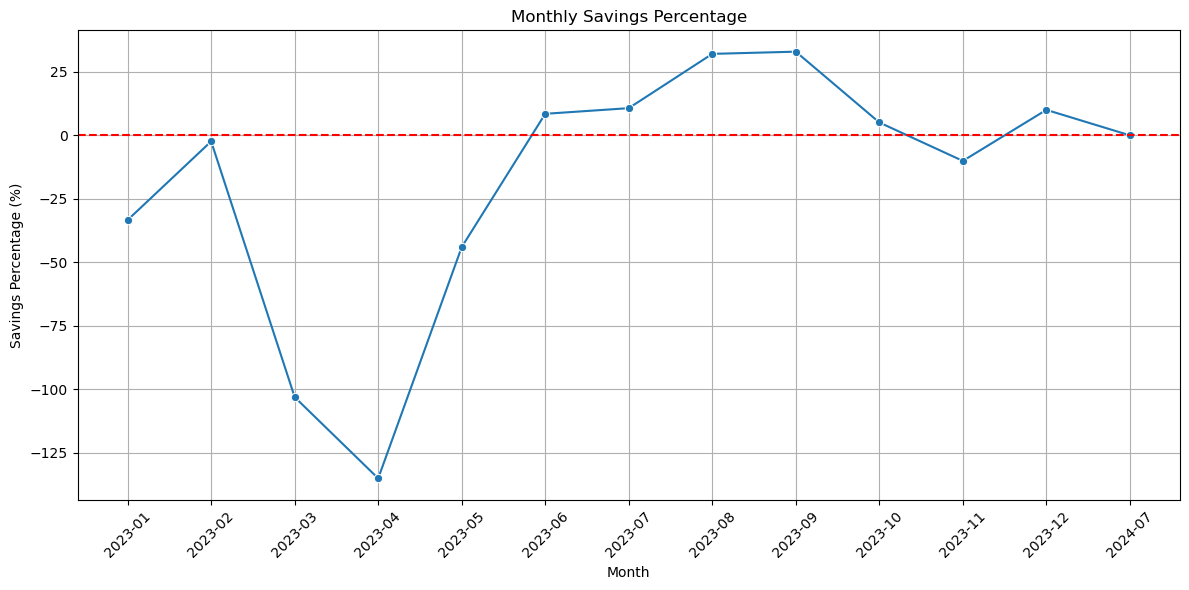

In [49]:
def savings_percentage(df):
    # Ensure 'Buchungsdatum' is a datetime object
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'])

    # Create a new column 'month' for grouping by month
    df['month'] = df['Buchungsdatum'].dt.to_period('M')

    # Calculate total income per month
    income = df[df['Betrag (€)'] > 0].groupby('month')['Betrag (€)'].sum()

    # Calculate total expenses per month (absolute values)
    expenses = df[df['Betrag (€)'] < 0].groupby('month')['Betrag (€)'].sum().abs()

    # Calculate savings percentage
    savings_percent = ((income - expenses) / income * 100).fillna(0)

    # Print the savings percentage per month
    print("\nSavings Percentage per Month:")
    print(savings_percent)

    # Plot the savings percentage
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=savings_percent.index.astype(str), y=savings_percent.values, marker='o')
    plt.title('Monthly Savings Percentage')
    plt.xlabel('Month')
    plt.ylabel('Savings Percentage (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()
    plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0 for reference
    plt.tight_layout()
    plt.show()

# Example usage
savings_percentage(df)

# 9. Cash Flow Stability
Calculate cash flow volatility to measure the consistency of your monthly income and expenses.


Cash Flow Volatility: -5.85


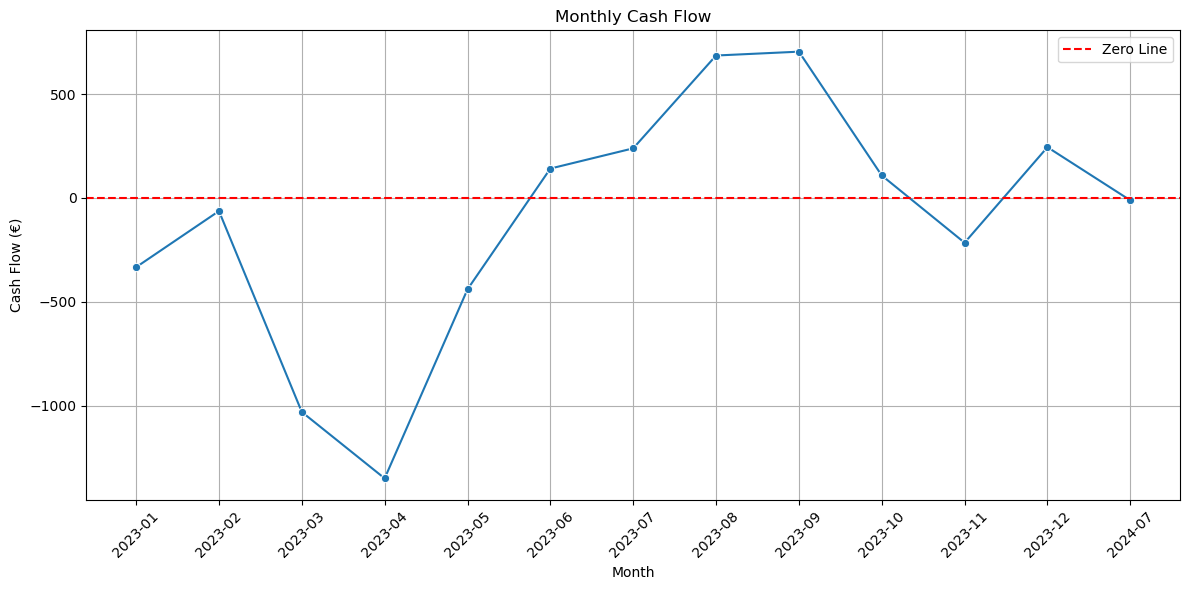

In [50]:
def cash_flow_volatility(df):
    # Ensure 'Buchungsdatum' is a datetime object
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'])
    
    # Create a new column 'month' for grouping by month
    df['month'] = df['Buchungsdatum'].dt.to_period('M')

    # Calculate monthly balance by summing 'Betrag (€)' for each month
    monthly_balance = df.groupby('month')['Betrag (€)'].sum()

    # Calculate cash flow volatility as the standard deviation of monthly balances divided by the mean
    volatility = monthly_balance.std() / monthly_balance.mean()

    # Print the calculated cash flow volatility
    print(f"\nCash Flow Volatility: {volatility:.2f}")

    # Plot the monthly balance to visualize trends and volatility
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=monthly_balance.index.astype(str), y=monthly_balance.values, marker='o')
    plt.title('Monthly Cash Flow')
    plt.xlabel('Month')
    plt.ylabel('Cash Flow (€)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.axhline(0, color='red', linestyle='--', label='Zero Line')  # Add a horizontal line at 0 for reference
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
cash_flow_volatility(df)

# 10. Income Sources Breakdown
Break down the sources of income (e.g., salary, refunds) by Zahlungspflichtige*r and analyze which contribute the most.


Income by Source:
Zahlungspflichtige*r
Compl3te GmbH                            13682.76
Bundesagentur für Arbeit-Service-Haus     5596.08
Hauptkasse des Freistaates Sachsen        1601.00
Helga Jakob-Stralka Norbert Stralka        300.00
Sophia-Theresa Richter                     150.00
Kolsch, Isabell                             95.00
TIEFGANG EVENTS GMBH                        60.00
ELISENDA BILLIG                             50.00
Name: Betrag (€), dtype: float64


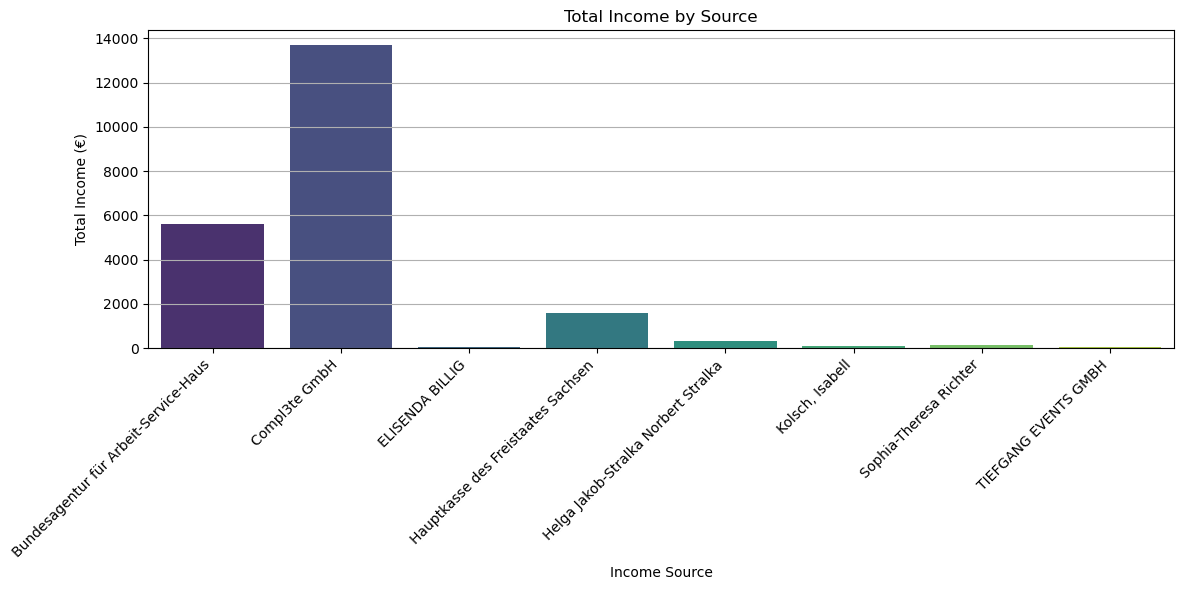

In [51]:
def income_by_source(df):
    # Ensure 'Betrag (€)' column is numeric
    df['Betrag (€)'] = pd.to_numeric(df['Betrag (€)'], errors='coerce')

    # Filter the DataFrame for positive amounts to get income
    income_data = df[df['Betrag (€)'] > 0]

    # Group by 'Zahlungspflichtige*r' and sum the 'Betrag (€)' to get total income by source
    income_summary = income_data.groupby('Zahlungspflichtige*r')['Betrag (€)'].sum()

    # Print the income summary sorted in descending order
    print("\nIncome by Source:")
    print(income_summary.sort_values(ascending=False))

    # Plot the income by source for better visualization
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot for income by source
    sns.barplot(x=income_summary.index, y=income_summary.values, palette='viridis')
    
    # Set plot title and labels
    plt.title('Total Income by Source')
    plt.xlabel('Income Source')
    plt.ylabel('Total Income (€)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add a grid for easier reading
    plt.grid(axis='y')
    
    # Adjust layout to make room for labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage
income_by_source(df)

# Plots 

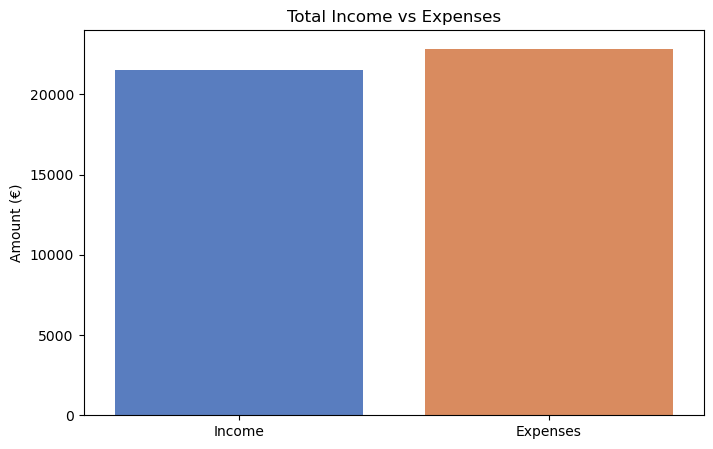

In [52]:
def plot_total_income_expenses(df):
    """
    Plots total income and expenses from the given DataFrame.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with a 'Betrag (€)' column.
    """
    # Calculate total income: sum of all positive amounts in 'Betrag (€)'
    total_income = df[df['Betrag (€)'] > 0]['Betrag (€)'].sum()

    # Calculate total expenses: sum of all negative amounts in 'Betrag (€)' (make positive for display)
    total_expenses = df[df['Betrag (€)'] < 0]['Betrag (€)'].sum()

    # Prepare data for plotting as a dictionary
    totals = {'Income': total_income, 'Expenses': abs(total_expenses)}  # Convert expenses to positive

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 5))  # Set figure size
    sns.barplot(x=list(totals.keys()), y=list(totals.values()), palette='muted')

    # Set the title and labels for the plot
    plt.title("Total Income vs Expenses")
    plt.ylabel("Amount (€)")
    
    # Show the plot
    plt.show()

plot_total_income_expenses(df)

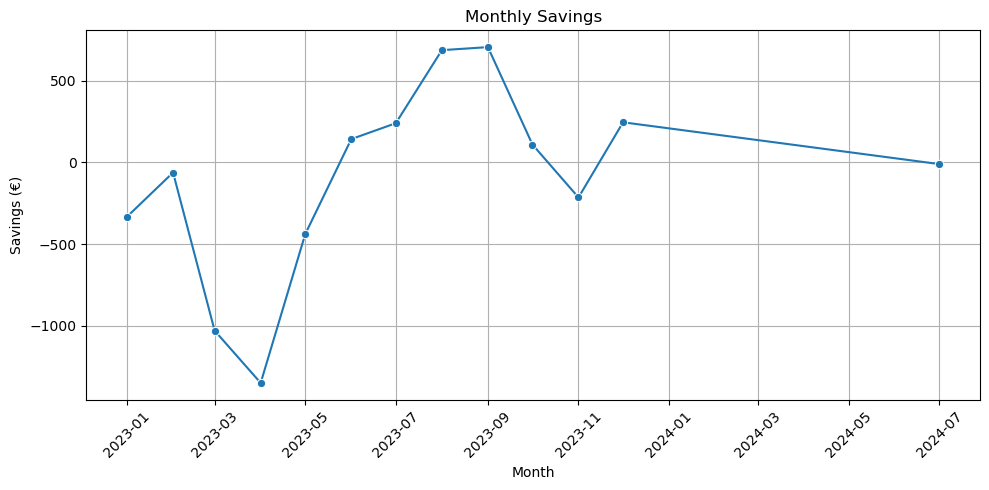

In [54]:
def plot_monthly_savings(df):
    """
    Plots monthly savings over time.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Buchungsdatum' and 'Betrag (€)' columns.
    """
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'], errors='coerce')

    # Group by month and calculate total savings (income minus expenses)
    df['month'] = df['Buchungsdatum'].dt.to_period('M')  # Extract month
    monthly_savings = df.groupby('month')['Betrag (€)'].sum().reset_index()

    # Convert 'month' back to a datetime object for plotting
    monthly_savings['month'] = monthly_savings['month'].dt.to_timestamp()

    # Plot
    plt.figure(figsize=(10, 5))  # Set figure size
    sns.lineplot(x='month', y='Betrag (€)', data=monthly_savings, marker='o')
    
    # Set title and labels
    plt.title('Monthly Savings')
    plt.ylabel('Savings (€)')
    plt.xlabel('Month')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid()  # Add grid for better visualization
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# Example execution
# Assuming 'df' is your DataFrame containing financial transactions
plot_monthly_savings(df)

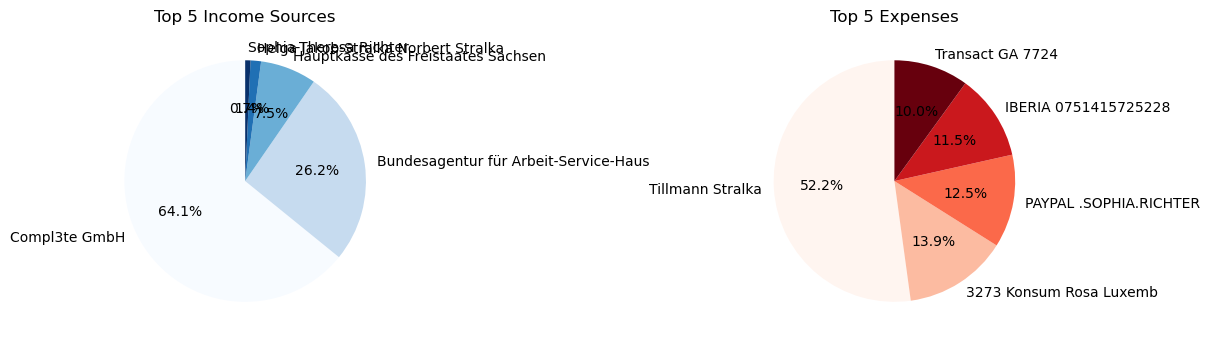

In [71]:
def plot_largest_expenses_income(df):
    """
    Plots the top 5 sources of income and the top 5 expenses in pie charts.
    
    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Betrag (€)', 'Zahlungspflichtige*r', and 'Zahlungsempfänger*in' columns.
    """
    # Top 5 sources of income
    top_income = df[df['Betrag (€)'] > 0].groupby('Zahlungspflichtige*r')['Betrag (€)'].sum().nlargest(5)
    
    # Top 5 expenses (convert to positive values for plotting)
    top_expenses = df[df['Betrag (€)'] < 0].groupby('Zahlungsempfänger*in')['Betrag (€)'].sum().nsmallest(5)
    top_expenses = top_expenses.abs()  # Convert expenses to positive values

    # Plot top 5 income sources
    plt.figure(figsize=(12, 6))  # Set figure size
    
    # Subplot for income
    plt.subplot(1, 2, 1)
    top_income.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Blues')
    plt.title("Top 5 Income Sources")
    plt.ylabel('')  # Hide the y-label for pie chart

    # Subplot for expenses
    plt.subplot(1, 2, 2)
    top_expenses.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='Reds')
    plt.title("Top 5 Expenses")
    plt.ylabel('')  # Hide the y-label for pie chart
    
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Example execution
plot_largest_expenses_income(df)



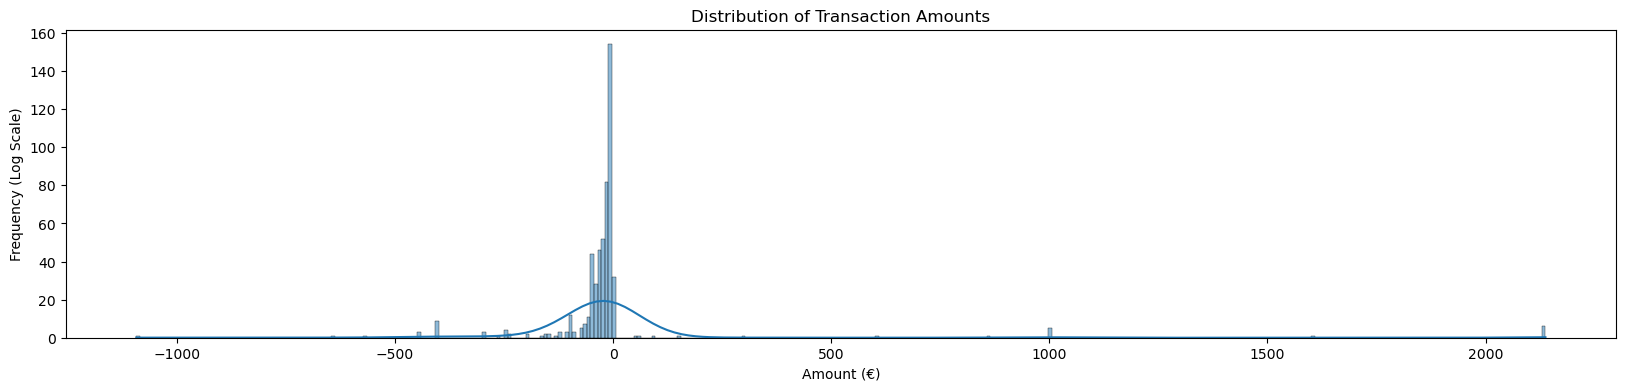

In [67]:
def plot_transaction_distribution(df):
    """
    Plots the distribution of transaction amounts using a histogram.

    Parameters:
    df (DataFrame): The DataFrame containing financial data with a 'Betrag (€)' column.

    This function generates a histogram that shows the frequency of transaction amounts,
    along with a Kernel Density Estimate (KDE) line to visualize the distribution's shape.
    The y-axis is set to a logarithmic scale to better visualize the distribution of 
    transaction amounts, especially when dealing with a wide range of values.
    """
    plt.figure(figsize=(20, 4)) 

    # Create the histogram with a KDE line
    sns.histplot(df['Betrag (€)'], kde=True)

    # Set the title and labels
    plt.title("Distribution of Transaction Amounts")
    plt.xlabel("Amount (€)")
    plt.ylabel("Frequency (Log Scale)")

    # Show the plot
    plt.show()

plot_transaction_distribution(df)    

In [69]:
def plot_monthly_income_vs_expenses(df):
    """
    Plots a stacked bar chart of monthly income versus expenses.

    Parameters:
    df (DataFrame): The DataFrame containing financial data with 'Buchungsdatum' and 'Betrag (€)' columns.

    This function calculates the total income and expenses per month and visualizes the data
    using a stacked bar chart. It categorizes the transactions as 'Income' or 'Expenses' based on
    the transaction amounts and groups them by month for comparison.
    """
    # Ensure 'Buchungsdatum' is in datetime format
    df['Buchungsdatum'] = pd.to_datetime(df['Buchungsdatum'])

    # Create a new column for the month
    df['month'] = df['Buchungsdatum'].dt.to_period('M').astype(str)  # Convert to string for better plotting

    # Classify transactions as Income or Expenses
    df['Type'] = df['Betrag (€)'].apply(lambda x: 'Income' if x > 0 else 'Expenses')
    
    # Group by month and transaction type, summing the amounts
    monthly_data = df.groupby(['month', 'Type'])['Betrag (€)'].sum().unstack().reset_index()

    # Plot using Plotly for interactive visualization
    fig = px.bar(monthly_data, x='month', y=['Income', 'Expenses'], 
                 title='Monthly Income vs Expenses',
                 labels={'value': 'Amount (€)', 'month': 'Month'},
                 barmode='stack')

    # Show the figure
    fig.show()

plot_monthly_income_vs_expenses(df)

# Next possible steps: 
# Make all the output into a text file with nice formating 
# Save all the plots also in the overview file (maybe rtf??)
# Make categorizer 
# Execute this with a dummy file into the data bevore publishing 

In [ ]:
# Give me list of all words in Verwendungszweck and group them 

# Extract the 'Verwendungszweck' column
verwendungszweck_series = df['Verwendungszweck']

# Combine all entries into a single string
all_text = ' '.join(verwendungszweck_series.dropna())

# Split the string into words
words = all_text.split()

# Get unique words
unique_words = set(words)

# Print unique words
for word in sorted(unique_words):
    print(word)

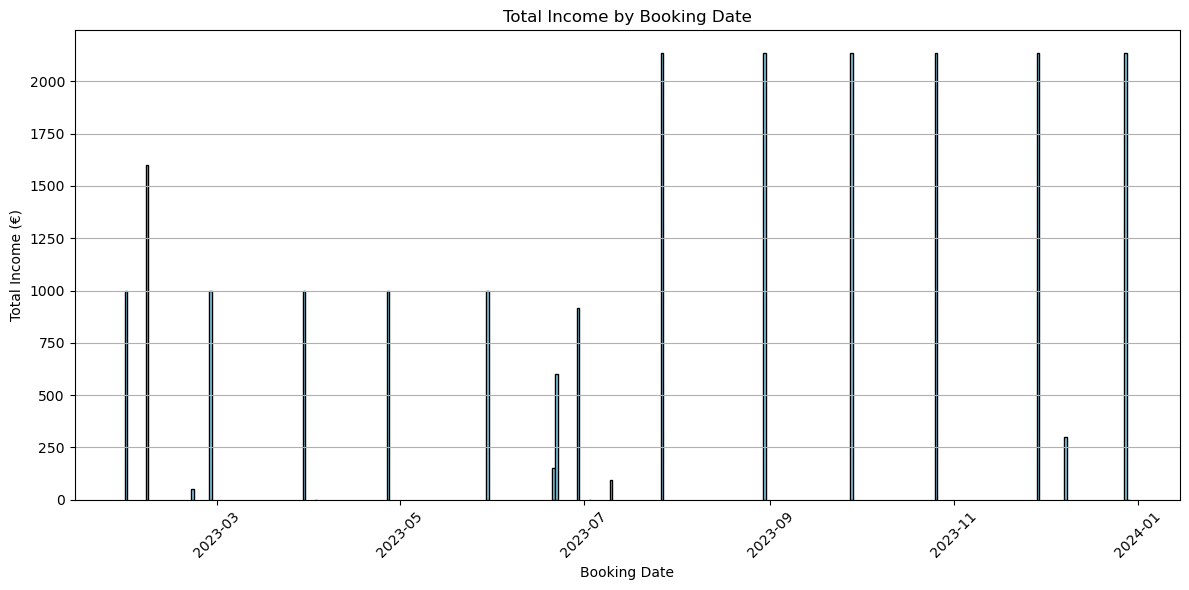

In [10]:
# Step 1: Filter the DataFrame for income entries
income_data = df[df['Umsatztyp'] == 'Eingang']

# Step 3: Group by Buchungsdatum and sum the Betrag (€) to get total income per date
total_income_per_date = income_data.groupby('Buchungsdatum')['Betrag (€)'].sum().reset_index()

# Step 4: Plotting the total income by booking date
plt.figure(figsize=(12, 6))
plt.bar(total_income_per_date['Buchungsdatum'], total_income_per_date['Betrag (€)'], color='skyblue', edgecolor='black')
plt.title('Total Income by Booking Date')  # Title of the plot
plt.xlabel('Booking Date')  # X-axis label
plt.ylabel('Total Income (€)')  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(axis='y')  # Add grid lines to y-axis
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

Data type of amounts: float64
    Year  Month  Betrag (€)
0   2023      1      999.00
1   2023      2     2650.00
2   2023      3      999.00
3   2023      4      999.00
4   2023      5      999.00
5   2023      6     1669.92
6   2023      7     2232.32
7   2023      8     2137.32
8   2023      9     2137.32
9   2023     10     2137.32
10  2023     11     2137.32
11  2023     12     2437.32


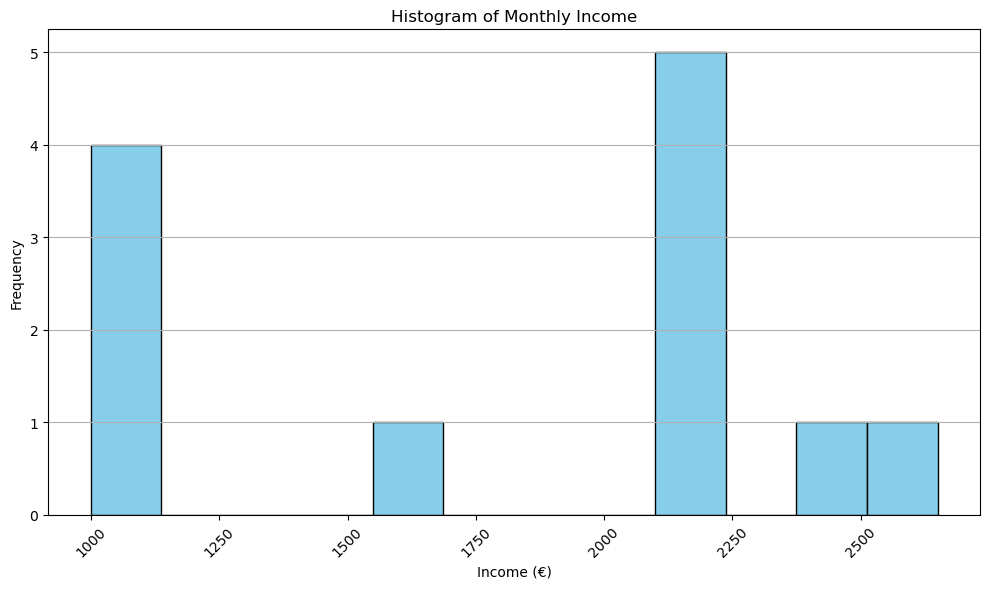

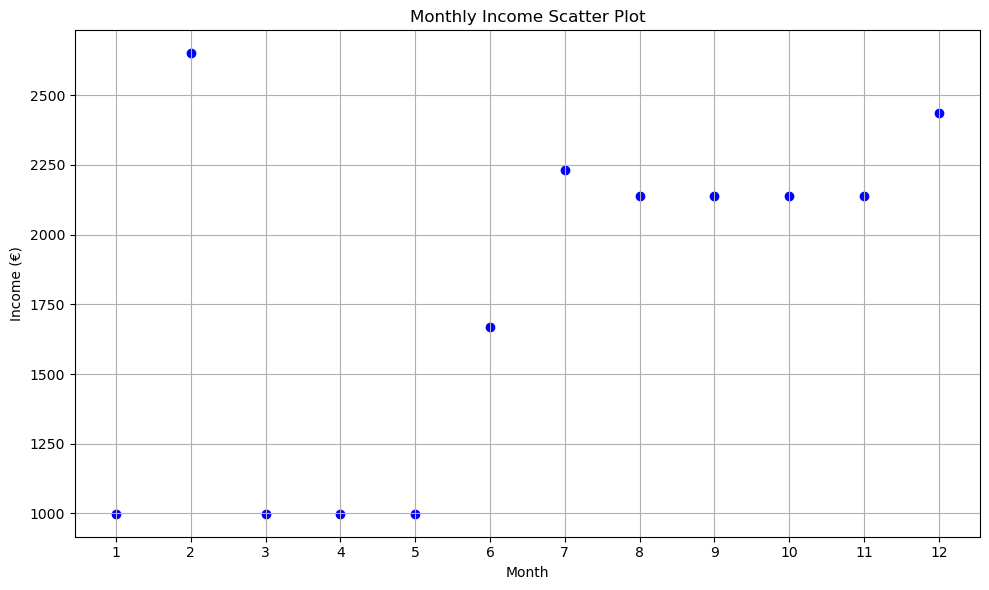

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        12 non-null     int64  
 1   Month       12 non-null     int64  
 2   Betrag (€)  12 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 416.0 bytes
None


In [8]:
# Step 1: Filter the DataFrame for income transactions
income = df[df['Umsatztyp'] == 'Eingang']  # Filter for 'Income' transactions

# Step 2: Convert the 'Buchungsdatum' to datetime format
income['Buchungsdatum'] = pd.to_datetime(income['Buchungsdatum'], errors='coerce')  # Coerce errors to NaT

# Step 3: Extract Year and Month from the 'Buchungsdatum'
income['Year'] = income['Buchungsdatum'].dt.year
income['Month'] = income['Buchungsdatum'].dt.month

# Step 4: Sum the amounts by Year and Month
income_aggregated = income.groupby(['Year', 'Month'])['Betrag (€)'].sum().reset_index()

# Remove rows with NaN in the 'Betrag (€)' column
income_aggregated.dropna(subset=['Betrag (€)'], inplace=True)

# Debugging: Print the data type and the aggregated DataFrame
print("Data type of amounts:", income_aggregated['Betrag (€)'].dtype)
print(income_aggregated)


# Step: Create a histogram of income amounts
plt.figure(figsize=(10, 6))
plt.hist(income_aggregated['Betrag (€)'], bins=len(income_aggregated['Month']), color='skyblue', edgecolor='black')  # Histogram
plt.title('Histogram of Monthly Income')  # Title of the plot
plt.xlabel('Income (€)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-ticks if necessary
plt.grid(axis='y')  # Add grid lines to y-axis
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

# Step: Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(income_aggregated['Month'], income_aggregated['Betrag (€)'], color='blue', marker='o')  # Scatter plot
plt.title('Monthly Income Scatter Plot')  # Title of the plot
plt.xlabel('Month')  # X-axis label
plt.ylabel('Income (€)')  # Y-axis label
plt.xticks(income_aggregated['Month'])  # Set x-ticks to show each month
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

print(income_aggregated.info())

### Read csv
Works for DKB csv as of 2022-12-31.

In [7]:
# Read metadata
with open(csv_file,"r",encoding="latin-1") as f:
    reader = csv.DictReader(f,delimiter=";")
    metadata = {}
    for i, row in enumerate(reader):
        if i < 3:
            key = None
            value = None
            for k, v in row.items():
                if k == "Kontonummer:":
                    key = row["Kontonummer:"]
                    continue
                if k == "":
                    continue
                value = v
            
            if ":" in key:
                key = key.replace(":","")
            if "Kontostand" in key:
                key = "Kontostand"
            if "EUR" in value:
                value = value.replace(" ","").replace("EUR","")

            metadata[key] = value
            
# print(metadata)

start_date = datetime.strptime(metadata["Von"],"%d.%m.%Y").date()
end_date = datetime.strptime(metadata["Bis"],"%d.%m.%Y").date()
end_balance = float(metadata["Kontostand"].replace(".","").replace(",","."))

NameError: name 'csv_file' is not defined

In [ ]:
print("start:",start_date)
print("end:",end_date)
print("end balance:",end_balance)

## Named Columns

In [ ]:
party = "Auftraggeber / Begünstigter"
category = "Kategorie"
amount = "Betrag (EUR)"
cause = "Verwendungszweck"
posting_text = "Buchungstext"
balance = "Kontostand (EUR)"

### Cleanup

In [ ]:
# Fix US / EU decimal-point/comma
data[amount] = data[amount].str.replace('.','')
data[amount] = data[amount].str.replace(',','.')
data[amount] = data[amount].astype('float')

# avoid nan being interpreted as float in specific columns
data[party] = data[party].astype(str)
data[cause] = data[cause].astype(str)
data[posting_text] = data[posting_text].astype(str)

In [ ]:
data.head()

### Remove small transactions to avoid noise

In [ ]:
data = data[abs(data[amount]) > 0.01]

### Inverse Dataframe to have first day first and filter by time-range

In [ ]:
from dateutil.relativedelta import relativedelta
if number_of_last_months_to_analyse > 0:
    start_date = end_date - relativedelta(months=number_of_last_months_to_analyse)
    
print(f"Analysing time range: {start_date} -> {end_date}")
data = data.loc[str(start_date):str(end_date)]
data = data.iloc[::-1]

In [ ]:
fr = data.index[0]
to = data.index[-1]
print(fr,"->",to)

### Compute balance at each transaction

In [ ]:
data_balance = data[amount].sum().round(2)
start_balance = end_balance - data_balance
data[balance] = data[amount].cumsum()+start_balance

In [ ]:
print("start",start_balance)
print("end",end_balance)
print("balance during csv timespan",data_balance)

## Balance over time

In [ ]:
data[balance].plot(
    title='Account balance DKB %s' % accountname,
    grid=True,
    figsize=(20,8)
);

## Breakdown by transaction party

In [ ]:
empfgroup = data.groupby(party).agg({amount:"sum"})

In [ ]:
# Short the names
empfgroup.index = [str(i)[:30] for i in empfgroup.index]

In [ ]:
empfgroup[amount].head()

In [ ]:
empfgroup = empfgroup.sort_values(amount,ascending=False)
gutschrift = empfgroup[amount] > 0
colors = list( map(lambda x: "g" if x else "r" , gutschrift) )

In [ ]:
empfgroup[empfgroup[amount].abs() > 50].plot.barh(
    figsize=(10,60),
    title=u'Aggregierte Zahlungen ab 50€ (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
  );

In [ ]:
data.head()

## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [ ]:
categories = {
    "eat_out_or_get_food": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Backerei",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "alltag_laden": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "vollcorner",
    ],
    "spezial_laden": [
        "karstadt",
        "galeria",
        "kaufhof",
        "mueller",
        "migros",
        "coop",
        "dm fil",
        "go asia",
        "Drogerie",
        "SUCKFUELL",
        "butlers",
        "Suckfull",
        "Bio-Market",
        "conrad m",
    ],
    "online_handel":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
    ],
    "transport": [
        "FERNVERKEHR",
        "flixbus",
        "PAYPAL .DBVERTR",
    ],
    "ausflug": [
        "hamburg",
        "Hotel",
        "PAYPAL .booking",
        "prague",
        "praha",
        "Tubingen",
    ],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "freizeit": [
        "VOLKSBAD",
        "PAYPAL .SENNHEISER",
    ],
    "entertainment": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix"
    ],
    "crypto": [
        "bitflyer",
        "coinbase"
    ],
    "health": [
        "apotheke",
        "Krankenversicherung",
    ],
    "cash": [
        "bargeld",
        "automat",
        "cash"
    ],
    "dkb": [
        "DKB",
        "KREDITBANK",
    ],
    "miete": [],
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    pt = x[posting_text].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)) or any(map(lambda r: r.lower() in pt, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

Breakdown by category. (Ignored transactions below 10€).

In [ ]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


### Category analysis

In [ ]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

In [ ]:
quick_category_analyse("investment",desc=cause)

In [ ]:
quick_category_analyse("dkb", desc=cause)

In [ ]:
quick_category_analyse("ausflug")

In [ ]:
quick_category_analyse("card_payment")

In [ ]:
quick_category_analyse("transport")